In [1]:
#libraries we need
import numpy as np 
import matplotlib.pyplot as plt
import load_mnist
import math
import time
import torch
from sklearn.utils import shuffle

In [2]:
#Training test plot curve code that was provided in assignment 1 to get the plots
#modified it to contain the time and number of epochs
def training_curve_plot(title, train_costs, test_costs, train_accuracy, test_accuracy, batch_size, learning_rate, time, epochs):
    lg=18
    md=13
    sm=9
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=1.15, fontsize=lg)
    sub = f'| Batch size:{batch_size} | Learning rate:{learning_rate} | Number of Epochs:{epochs} | Training Time:{round(time)}sec |'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
    x = range(1, len(train_costs)+1)
    axs[0].plot(x, train_costs, label=f'Final train cost: {train_costs[-1]:.4f}')
    axs[0].plot(x, test_costs, label=f'Final test cost: {test_costs[-1]:.4f}')
    axs[0].set_title('Costs', fontsize=md)
    axs[0].set_xlabel('Epochs', fontsize=md)
    axs[0].set_ylabel('Cost', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    # Optionally use a logarithmic y-scale
    #axs[0].set_yscale('log')
    axs[1].plot(x, train_accuracy, label=f'Final train accuracy: {100*train_accuracy[-1]:.2f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test accuracy: {100*test_accuracy[-1]:.2f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Epochs', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)


In [3]:
#get the train and test data from the dataset
xtrain,ytrain,xtest,ytest = load_mnist.load_mnist()
#looking at the output
print("X Train shape", xtrain.shape)
print("Y Train shape", ytrain.shape)
print("X Test shape", xtest.shape)
print("Y Test shape", ytest.shape)

X Train shape (60000, 784)
Y Train shape (60000, 10)
X Test shape (10000, 784)
Y Test shape (10000, 10)


In [4]:
#converting to Tensors for easy PyTorch implementation
xtrain = torch.Tensor(xtrain)
ytrain = torch.Tensor(ytrain)
xtest = torch.Tensor(xtest)
ytest = torch.Tensor(ytest)

In [5]:
#first we want to put our data in a pytorch dataset so we can mini batch and enumerate through it later more easily
train_dataset = torch.utils.data.TensorDataset(xtrain, ytrain)
test_dataset = torch.utils.data.TensorDataset(xtest, ytest)

In [6]:
#calculating the accuracy given outputs not softmaxed and labels one hot encoding.
def calculate_accuracy(outputs, labels):
    #don't need to softmax because the max value will be the max softmax we just pull the index to get the digit prediction 
    _, output_index = torch.max(outputs,1)
    #get the index/ digit of the label
    _, label_index = torch.max(labels, 1)
    # return the number of correct matches and divide by the size to get accuracy
    return (output_index == label_index).sum().item()/labels.size(0)

## Exercise 1
Want to make the exact same NN that I did in assignment 1 and the line below is the code I used for the deep NN  
```deep_model = numpyNN(k = 2, activation_function="ReLU", mini_batch=128, epochs= 150, iterations = 300000, alpha = 0.01)```  
And the rest of the init function for my class looked like  
```def __init__(self, k = 2, d = 50, d_i = 784, d_o = 10, activation_function = "ReLU", alpha = 0.05, mini_batch = 100, iterations = 100000, x_train = xtrain, y_train=ytrain, x_test = xtest, y_test = ytest, epochs = 500):```  
So using Pytorch I want to create a deep fully connected NN with 2 hidden layers, 50 nodes per hidden layer, 784 is the input, 10 is the output, activation function is ReLU, a mini batch of 128, 150 epochs, and learning rate of 0.01. The epochs parameter ended training before iterations in this context and size we want to compare epochs we will focus on this instead of iterations from now on.

In [9]:
# Here we make a neural network that is identical to the one in assignment 1
# so it will be a deep NN of 2 hidden layers, 50 nodes per layer
class Assignment1NN(torch.nn.Module):
    def __init__(self, input_size = 784, hidden_size = 50, output_size = 10):
        super().__init__()
        #First hiddent layer
        self.hidden1 = torch.nn.Linear(input_size, hidden_size)
        #ReLU activation function
        self.relu1 = torch.nn.ReLU()
        #second hidder layer
        self.hidden2 = torch.nn.Linear(hidden_size, hidden_size)
        #ReLU activation function
        self.relu2 = torch.nn.ReLU()
        #output layer
        self.output = torch.nn.Linear(hidden_size, output_size)
    #forward pass through the network
    def forward(self, x):
        #pass through first hidden layer
        x = self.hidden1(x)
        #activation function
        x = self.relu1(x)
        #hidden layer 2
        x = self.hidden2(x)
        #activation function
        x = self.relu2(x)
        #pass through the output layer
        x = self.output(x)
        return x

# setting the hyperparameters for exercise 1
input_size_1 = 784
num_classes_1 = 10
learning_rate_1 = 0.01
batch_size_1 = 128
num_epochs_1 = 150

#Making a dataloader for this specific NN which is a wrapper around the Dataset for easy use
train_loader_1 = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_1, shuffle=True)
#make the batch size for the test DataLoader the size of the dataset for evaluation.
test_loader_1 = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = xtest.shape[0], shuffle=True)

#This is the Neural Network model
model_1 = Assignment1NN(input_size = input_size_1, hidden_size = 50, output_size = num_classes_1)
#Our loss function will be cross entropy since we are getting a probability distribution
loss_1 = torch.nn.CrossEntropyLoss()
#Here we are going to use classic stochastic gradient descent without any special optimizations
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr= learning_rate_1)

#arrays for our plots
training_loss_1 = []
training_accuracy_1 = []
test_loss_1 = []
test_accuracy_1 =[]
#find the start time
start_1 = time.time()

#Setting up the training loop
print("Starting the Training Loop")
for epoch in range(num_epochs_1):
    #keep the loss and accuracies after each mini batch
    batch_loss = []
    batch_accuracy = []
    #loop through a mini-batch
    for batch_index, (data, label) in enumerate(train_loader_1):
        # Forward pass
        outputs = model_1(data)
        #evaluate the loss
        loss = loss_1(outputs, label)
        #append the loss to the batch loss
        batch_loss.append(loss.item())
        #calculate the accuracy based on the outputs (not softmaxed) and labels. Do outputs.data so we don't pass gradient info
        batch_accuracy.append(calculate_accuracy(outputs.data, label))

        # Backward pass setting gradients to zero
        optimizer_1.zero_grad()
        #calcualting gradients
        loss.backward()
        #updating parameters
        optimizer_1.step()

    #add to the training epoch accuracies and losses
    training_accuracy_1.append(np.average(batch_accuracy))
    training_loss_1.append(np.average(batch_loss))
    #get the test loss and accuracy
    #change mode
    model_1.eval()
    #so we don't accidentally change anything
    with torch.no_grad():
        #get the "batch" of the test data which is all of it
        for batch_index, (data, label) in enumerate(test_loader_1):
            #get our test predicitons
            test_predictions = model_1(data)
            #test loss
            loss = loss_1(test_predictions, label)
            #append statistics
            test_loss_1.append(loss)
            test_accuracy_1.append(calculate_accuracy(test_predictions.data, label))
    #back to training mode
    model_1.train()

    print(f"Epoch: {epoch} done")

#end time and get the total time
end_1 = time.time()
total_time = end_1 - start_1

Starting the Training Loop
Epoch: 0 done
Epoch: 1 done
Epoch: 2 done
Epoch: 3 done
Epoch: 4 done
Epoch: 5 done
Epoch: 6 done
Epoch: 7 done
Epoch: 8 done
Epoch: 9 done
Epoch: 10 done
Epoch: 11 done
Epoch: 12 done
Epoch: 13 done
Epoch: 14 done
Epoch: 15 done
Epoch: 16 done
Epoch: 17 done
Epoch: 18 done
Epoch: 19 done
Epoch: 20 done
Epoch: 21 done
Epoch: 22 done
Epoch: 23 done
Epoch: 24 done
Epoch: 25 done
Epoch: 26 done
Epoch: 27 done
Epoch: 28 done
Epoch: 29 done
Epoch: 30 done
Epoch: 31 done
Epoch: 32 done
Epoch: 33 done
Epoch: 34 done
Epoch: 35 done
Epoch: 36 done
Epoch: 37 done
Epoch: 38 done
Epoch: 39 done
Epoch: 40 done
Epoch: 41 done
Epoch: 42 done
Epoch: 43 done
Epoch: 44 done
Epoch: 45 done
Epoch: 46 done
Epoch: 47 done
Epoch: 48 done
Epoch: 49 done
Epoch: 50 done
Epoch: 51 done
Epoch: 52 done
Epoch: 53 done
Epoch: 54 done
Epoch: 55 done
Epoch: 56 done
Epoch: 57 done
Epoch: 58 done
Epoch: 59 done
Epoch: 60 done
Epoch: 61 done
Epoch: 62 done
Epoch: 63 done
Epoch: 64 done
Epoch: 6

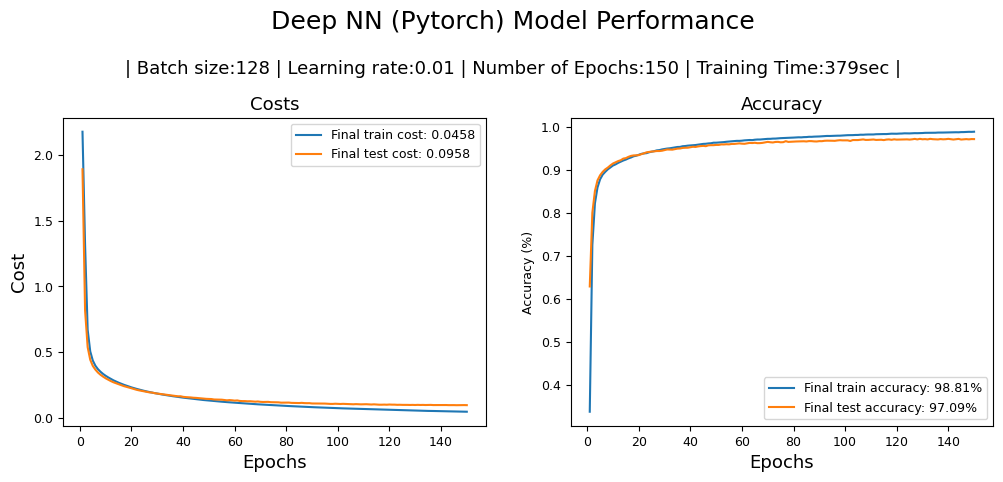

In [11]:
training_curve_plot("Deep NN (Pytorch) Model Performance", training_loss_1, test_loss_1, training_accuracy_1, test_accuracy_1, 
128, 0.01, total_time, num_epochs_1)

In [14]:
sum_1 = 0
for param in model_1.parameters():
    sum_1 += param.numel()
print(sum_1)

42310


## Exercise 2  
Implement a convolutional neural network

In [49]:
#will use local computer GPU to speed up training
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
print(torch.cuda.is_available())  # True if CUDA is available
print(torch.cuda.device_count())  # Number of GPUs available
print(torch.cuda.current_device())  # Current GPU index
print(torch.cuda.get_device_name(0))  # Name of the GPU

Using device: cuda
True
1
0
NVIDIA GeForce RTX 4050 Laptop GPU


In [52]:
# since we are now working with a convolutional neural network we need to reshape the data to be a 2D array for x
# y stays the same 
#reshape to N, Channels, height, width
xtrain_cnn = xtrain.reshape(60000, 1,28,28).to(device)
xtest_cnn = xtest.reshape(10000, 1,28,28).to(device)
ytrain_cnn = ytrain.to(device)
ytest_cnn = ytest.to(device)
#make our datasets so we can make data loaders
train_dataset_cnn = torch.utils.data.TensorDataset(xtrain_cnn, ytrain_cnn)
test_dataset_cnn = torch.utils.data.TensorDataset(xtest_cnn, ytest_cnn)

In [ ]:
#make the CNN for exercise 2 according to the specifications in the assignment
class Exercise2CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #1 input channel, 8 output channels, kernel size 3, stride 1, padding 1
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
        #non linearity
        self.relu1 = torch.nn.ReLU()
        #first pooling layer with kernel size 2, stride 2 reduces image to (8,14,14)
        self.pool1 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        #8 input channels, 16 output channels, kernel size 3, stride 1 padding 1
        self.conv2 = torch.nn.Conv2d(in_channels= 8,out_channels= 16 , kernel_size= 3, stride= 1, padding= 1)
        #non linearity
        self.relu2 = torch.nn.ReLU()
        #second pooling layer with kernel size 2, stride 2 reduces image to (16,7,7)
        self.pool2 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        # 16 inputs, 32 outputs, kernel size 3, stride 1, padding 1
        self.conv3 = torch.nn.Conv2d(in_channels= 16,out_channels= 32 , kernel_size= 3, stride= 1, padding= 1)
        #non linearity
        self.relu3 = torch.nn.ReLU()
        #output netwrok we have 32 channels and an image that is (7,7)
        self.output = torch.nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        #pass through the first convolution and relu and pooling layers
        x = self.pool1(self.relu1(self.conv1(x)))
        #pass through the second convolution and relu and pooling layers
        x = self.pool2(self.relu2(self.conv2(x)))
        #pass through the final convolution and relu
        x = self.relu3(self.conv3(x))
        #flatten all dimensions except batch dimension which is dimension 0 so we start at 1
        x = torch.flatten(x, 1)
        #pass through our output layer
        x = self.output(x)
        return x

#want to set some hyperparameters 
learning_rate_2 = 0.01
batch_size_2 = 128
num_epochs_2 = 100

#Making a dataloader for this specific CNN which is a wrapper around the Dataset for easy use
train_loader_2 = torch.utils.data.DataLoader(dataset=train_dataset_cnn, batch_size=batch_size_1, shuffle=True)
#make the batch size for the test DataLoader the size of the dataset for evaluation.
test_loader_2 = torch.utils.data.DataLoader(dataset=test_dataset_cnn, batch_size = ytest.shape[0], shuffle=True)

#Make the CNN neural netowrk model
model_2 = Exercise2CNN().to(device)
#Our loss function will be cross entropy since we are getting a probability distribution
loss_2 = torch.nn.CrossEntropyLoss()
#Here we are going to use classic stochastic gradient descent without any special optimizations since we will change this later
optimizer_2 = torch.optim.SGD(model_2.parameters(), lr= learning_rate_2)

#arrays for our plots
training_loss_2 = []
training_accuracy_2 = []
test_loss_2 = []
test_accuracy_2 =[]
#find the start time
start_2 = time.time()

#Setting up the training loop
print("Starting the Training Loop")
for epoch in range(num_epochs_2):
    #keep the loss and accuracies after each mini batch
    batch_loss = []
    batch_accuracy = []
    #loop through a mini-batch
    for batch_index, (data, label) in enumerate(train_loader_2):
        # Forward pass
        outputs = model_2(data)
        #evaluate the loss
        loss = loss_2(outputs, label)
        #append the loss to the batch loss
        batch_loss.append(loss.item())
        #calculate the accuracy based on the outputs (not softmaxed) and labels. Do outputs.data so we don't pass gradient info
        batch_accuracy.append(calculate_accuracy(outputs.data, label))

        # Backward pass setting gradients to zero
        optimizer_2.zero_grad()
        #calcualting gradients
        loss.backward()
        #updating parameters
        optimizer_2.step()

    #add to the training epoch accuracies and losses
    training_accuracy_2.append(np.average(batch_accuracy))
    training_loss_2.append(np.average(batch_loss))
    #get the test loss and accuracy
    #change mode
    model_2.eval()
    #so we don't accidentally change anything
    with torch.no_grad():
        #get the "batch" of the test data which is all of it
        for batch_index, (data, label) in enumerate(test_loader_2):
            #get our test predicitons
            test_predictions = model_2(data)
            #test loss and move to cpu so I can plot
            loss = loss_2(test_predictions, label).to("cpu")
            #append statistics
            test_loss_2.append(loss)
            test_accuracy_2.append(calculate_accuracy(test_predictions.data, label))
    #back to training mode
    model_2.train()

    print(f"Epoch: {epoch} done. Test loss {test_loss_2[epoch]}. Test accuracy {test_accuracy_2[epoch]}")

#end time and get the total time
end_2 = time.time()
total_time = end_2 - start_2

Starting the Training Loop


In [71]:
test_loss_2

[tensor(0.5400, device='cuda:0'),
 tensor(0.3363, device='cuda:0'),
 tensor(0.2703, device='cuda:0'),
 tensor(0.1941, device='cuda:0'),
 tensor(0.1660, device='cuda:0'),
 tensor(0.1406, device='cuda:0'),
 tensor(0.1192, device='cuda:0'),
 tensor(0.1106, device='cuda:0'),
 tensor(0.0925, device='cuda:0'),
 tensor(0.0942, device='cuda:0')]

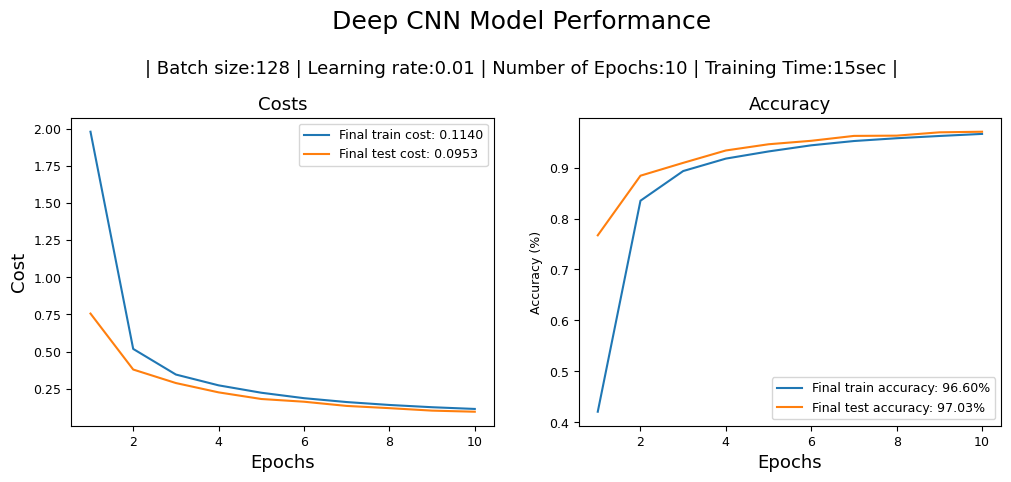

In [73]:
training_curve_plot("Deep CNN Model Performance", training_loss_2, test_loss_2, training_accuracy_2, test_accuracy_2, 
128, 0.01, total_time, num_epochs_2)